In [1]:
import math
import json

import keras
import librosa
import os

import numpy
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn


class_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]
print(tf.config.list_physical_devices('GPU'))

def preprocess(dataset_path, num_mfcc=40, n_fft=2048, hop_length=512, num_segment=10):
    data = {"labels":[], "mfcc":[], "track_id":[], "mel_spectrogram":[]}
    sample_rate = 22050
    sample_per_segment = int(sample_rate*30/num_segment)

    for label_idx, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath == dataset_path:
            continue
        for f in sorted(filenames):
            if not f.endswith('.wav'):
                continue
            file_path = str(str(dirpath).split('\\')[-1]) + '/' + str(f)
            # print("Track Name", file_path)

            try:
                y, sr = librosa.load(path=dirpath + "\\" + f, sr=sample_rate)
            except:
                print("Exception")
                continue
            for n in range(num_segment):
                # if (file_path == 'jazz/jazz.00055.wav'):
                #     print(n)
                mfcc = librosa.feature.mfcc(y=y[sample_per_segment*n: sample_per_segment*(n + 1)],
                                            sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft,
                                            hop_length=hop_length)
                mfcc = mfcc.T
                if mfcc.shape[0] == math.ceil(sample_per_segment / hop_length):
                    data["mfcc"].append(mfcc.tolist())
                    data["labels"].append(label_idx-1)
                else:
                    print("Error ", f)
                    # data["track_id"].append(f.split(".")[0])
    return data

KeyboardInterrupt: 

In [8]:
def prepare_datasets(test_size, validation_size):

    mfcc_data = preprocess(r"C:\Users\dpetr\Desktop\sxoli\music genre classification\MFCC-CNN\Data\genres_original")
    x = np.array(mfcc_data["mfcc"])
#     print(x.shape)
    y = np.array(mfcc_data["labels"])
#     print(y.shape)
#     print(numpy.unique(y))

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=validation_size)

    x_train = x_train[..., np.newaxis]
    x_validation = x_validation[..., np.newaxis]
    x_test = x_test[..., np.newaxis]

    return x_train, x_test, x_validation, y_train, y_test, y_validation


x_train, x_test, x_validation, y_train, y_test, y_validation = prepare_datasets(test_size=0.2, validation_size=0.25)

print(x_train.shape, x_validation.shape, x_test.shape)

Error  classical.00051.wav
Error  country.00007.wav
Error  disco.00014.wav
Error  hiphop.00032.wav


C:\Users\dpetr\miniconda3\envs\tf\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


Exception
(5991, 130, 40, 1) (1997, 130, 40, 1) (1998, 130, 40, 1)


In [7]:
mean = np.mean(x_train)
std = np.std(x_train)
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std
x_validation = (x_validation - mean) / std

In [2]:
# def manipulate(data, noise_factor):
#     noise = np.random.randn(len(data))
#     augmented_data = data + noise_factor * noise
#     # Cast back to same data type
#     augmented_data = augmented_data.astype(type(data[0]))
#     return augmented_data
#
# manipulate(x_train, 0.5)
# manipulate(y_train, 0.5)

MemoryError: Unable to allocate 2.72 TiB for an array with shape (11986, 65, 40, 11986) and data type float64

In [109]:
def build_model(input_shape):
    
    #create model
    model = keras.Sequential()
    
    #1st conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(0.00005)))
    model.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(0.2))
    
    #2nd conv layer
    model.add(keras.layers.Conv2D(128, (3, 3), input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(0.00005)))
    model.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(0.2))
    
    #3rd conv layer
    model.add(keras.layers.Conv2D(128, (3, 3), input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(0.00005)))
    model.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(0.2))
    
    model.add(keras.layers.GlobalAveragePooling2D())
    model.add(keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))) # 512 best
    model.add(keras.layers.Dropout(0.6))

    model.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.Dropout(0.6))
    
    #output layer
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    return model

In [110]:
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
model = build_model(input_shape)
optimizer = keras.optimizers.Adam(learning_rate=0.00015)
model.compile(optimizer=optimizer, 
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [112]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_78 (Conv2D)          (None, 128, 38, 64)       640       
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 64, 19, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_77 (Bat  (None, 64, 19, 64)       256       
 chNormalization)                                                
                                                                 
 re_lu_77 (ReLU)             (None, 64, 19, 64)        0         
                                                                 
 dropout_127 (Dropout)       (None, 64, 19, 64)        0         
                                                                 
 conv2d_79 (Conv2D)          (None, 62, 17, 128)     

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_78 (Conv2D)          (None, 128, 38, 64)       640       
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 64, 19, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_77 (Bat  (None, 64, 19, 64)       256       
 chNormalization)                                                
                                                                 
 re_lu_77 (ReLU)             (None, 64, 19, 64)        0         
                                                                 
 dropout_127 (Dropout)       (None, 64, 19, 64)        0         
                                                                 
 conv2d_79 (Conv2D)          (None, 62, 17, 128)     

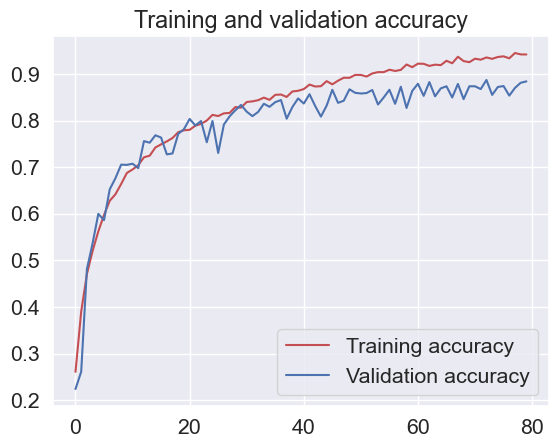

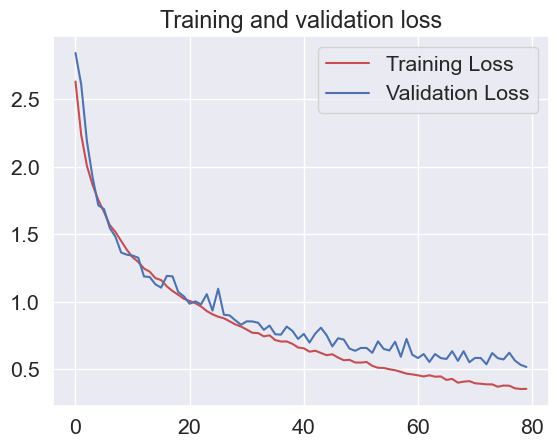

Accuracy on test set is:0.8893893957138062


In [113]:


model.summary()

history = model.fit(x_train, y_train,
          validation_data=(x_validation, y_validation),
          epochs=80,
          batch_size=32
          )

test_error, test_accuracy = model.evaluate(x_test, y_test, verbose=1)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy' + str())
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

print("Accuracy on test set is:{}".format(test_accuracy))



63/63 [==============================] - 1s 10ms/step


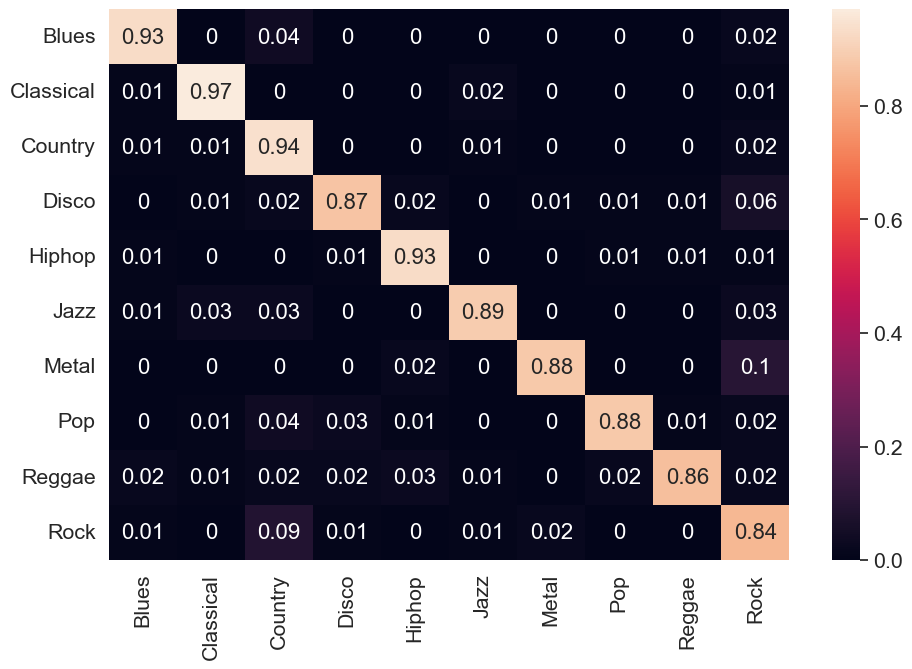

In [78]:
predictions = model.predict(x_test, batch_size=32, verbose=1)
predicted_indexes = []
for prediction in predictions:
    predicted_indexes.append(np.argmax(prediction))
predicted_indexes
conf_mat = confusion_matrix(y_test, predicted_indexes, normalize= 'true')
conf_mat = np.round(conf_mat, 2)
conf_mat_df = pd.DataFrame(conf_mat, columns= class_names, index= class_names)
plt.figure(figsize = (10,7), dpi = 100)
sn.set(font_scale=1.4)
sn.heatmap(conf_mat_df, annot=True, annot_kws={"size": 16}) # font size
plt.tight_layout()

In [48]:
model.save('saved_models/CNN-best')

INFO:tensorflow:Assets written to: saved_models/CNN-best\assets


INFO:tensorflow:Assets written to: saved_models/CNN-best\assets


In [132]:
model = tf.keras.models.load_model('saved_models/CNN')
test_error, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Accuracy on test set is:{}".format(test_accuracy))

63/63 [==============================] - 1s 11ms/step - loss: 0.5164 - accuracy: 0.8864
Accuracy on test set is:0.8863863945007324


In [133]:
def predict(model,x, y):
    
    x = x[np.newaxis, ...]
    prediction = model.predict(x)
    predicted_index = np.argmax(prediction, axis=1)
    print(f"Expected index: {y}, Predicted index:{predicted_index}")
    
x = x_test[228]
y = y_test[228]
predict(model, x, y)

1/1 [==============================] - 0s 125ms/step
Expected index: 9, Predicted index:[9]


In [72]:
best = keras.models.load_model('saved_models/CNN-best')

In [73]:
best.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 128, 38, 64)       640       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 64, 13, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_27 (Bat  (None, 64, 13, 64)       256       
 chNormalization)                                                
                                                                 
 re_lu_27 (ReLU)             (None, 64, 13, 64)        0         
                                                                 
 dropout_45 (Dropout)        (None, 64, 13, 64)        0         
                                                                 
 conv2d_28 (Conv2D)          (None, 62, 11, 128)      